#### Header
This part will use TENSORFLOW backend for KERAS API

In [1]:
import os
import time
import warnings
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

Using TensorFlow backend.


#### Hide warnings

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

#### Data Loader
This module will load the data and return it with train test split

In [3]:
def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'rb').read()
    data = f.decode().split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]


#### Data normalisers

In [4]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

#### Model builder
3 layers are there
* 1 Input = Contains feature of 50, in this use case
* 1 hidden = maps 50 to 100 feature space
* 1 output = Fully connected to work with linear activation for regression type action

In [5]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

#### Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time

In [6]:
def predict_point_by_point(model, data):
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

In [7]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [15]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white', figsize=[15,10])
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

In [13]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    plt.figure(figsize=[15,10])
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

> Loading data... 
> Data Loaded. Compiling...
> Compilation Time :  0.03886699676513672
Train on 3523 samples, validate on 186 samples
Epoch 1/1
3523/3523 [==============================] - 5s 1ms/step - loss: 0.0025 - val_loss: 0.0012
Training duration (s) :  10.900027990341187


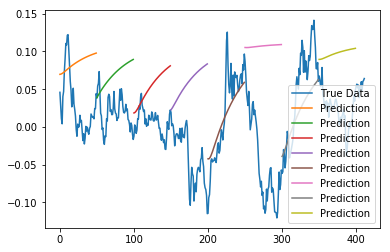

In [10]:
global_start_time = time.time()
epochs  = 1
seq_len = 50

print('> Loading data... ')

X_train, y_train, X_test, y_test = load_data('sp500.csv', seq_len, True)

print('> Data Loaded. Compiling...')

model = build_model([1, 50, 100, 1])

model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=epochs,
    validation_split=0.05)

predictions = predict_sequences_multiple(model, X_test, seq_len, 50)
#predicted = lstm.predict_sequence_full(model, X_test, seq_len)
#predicted = lstm.predict_point_by_point(model, X_test)        

print('Training duration (s) : ', time.time() - global_start_time)
plot_results_multiple(predictions, y_test, 50)

#### Single Point prediction result

In [11]:
predictions = predict_point_by_point(model, X_test)

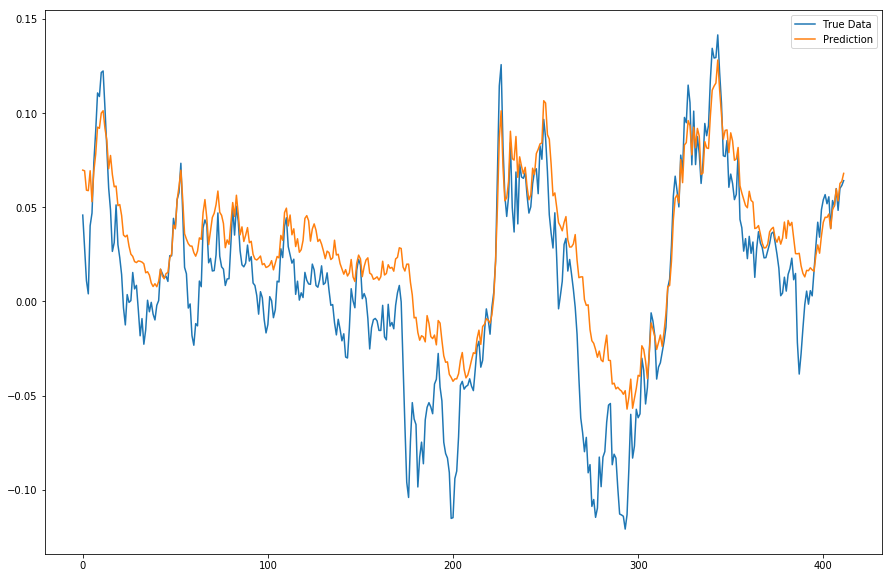

In [16]:
plot_results(predictions, y_test)